# Santander Customer Satisfaction

## Initialization

### Dependencies

In [2]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns

### Visualization Settings

In [3]:
%matplotlib inline
pd.options.display.float_format = '{:.6f}'.format
sns.set(style="white", color_codes=True)

### Files

In [4]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

## Data Exploring

In [5]:
train.shape

(76020, 371)

In [6]:
test.shape

(75818, 370)

In [7]:
set(train.columns) - set(test.columns)

{'TARGET'}

### Overview

In [8]:
n_customers = len(train)
n_unsatisfied = train.TARGET.sum()
n_satisfied = (train.TARGET==0).sum()
satisfaction_rate = float(n_satisfied)/n_customers

features = test.columns.drop('ID').tolist()
n_features = len(features)

print("Total number of customers: {}".format(n_customers))
print("Number of satisfied customers: {}".format(n_satisfied))
print("Number of unsatisfied customers: {}".format(n_unsatisfied))
print("Satisfaction rate: {:.2f}%".format(satisfaction_rate*100))
print("Number of features: {}".format(n_features))

Total number of customers: 76020
Number of satisfied customers: 73012
Number of unsatisfied customers: 3008
Satisfaction rate: 96.04%
Number of features: 369


### ID Analysis

In [9]:
if len(set(train.ID)) == len(train):
    print('No repeated ID')

No repeated ID


In [10]:
train_id = train.ID
test_id = test.ID
train.drop('ID', inplace=True, axis=1)
test.drop('ID', inplace=True, axis=1)

### Target Analysis

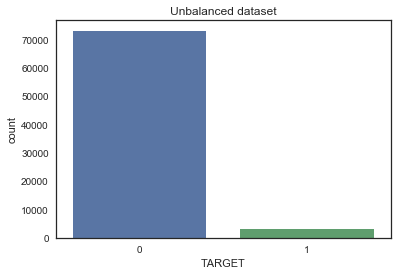

In [10]:
sns.countplot(train.TARGET);
plt.title('Unbalanced dataset');

### Exploring Features

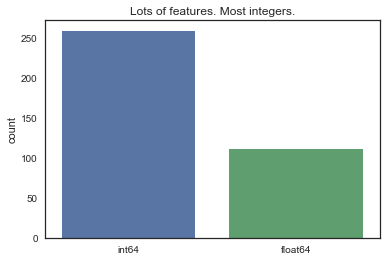

In [11]:
sns.countplot(train.dtypes);
plt.title('Lots of features. Most integers.');

## Data Preparation

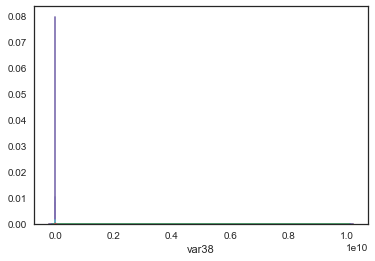

In [13]:
for c in train.select_dtypes('float'):
    sns.distplot(train[c]);

### Cleaning

In [11]:
def replace_weird(dfs, weird = [-999999, 9999999999.00]):
    for df in dfs:
        modes = df.mode()
        for col in df.columns:
            if any([i in df[col].values for i in weird]):
#                 df['weird_'+col] = df[col].isin(weird)
                df[col].mask(df[col].isin(weird), modes[col][0], inplace=True)

replace_weird([train, test])

In [12]:
def remove_useless(dfs):
    remove = []
    for df in dfs:
        for col in df.columns:
            if df[col].std() == 0:
                remove.append(col)
    for df in dfs:
        df.drop(set(remove), axis=1, inplace=True)

remove_useless([train, test])

In [13]:
def duplicated(df):
    duplicated = []
    c = df.columns
    for i in range(len(c)-1):
        v = df[c[i]].values
        for j in range(i+1,len(c)):
            if np.array_equal(v,df[c[j]].values):
                duplicated.append(c[j])
    return set(duplicated)


duplicated_train = duplicated(train)
duplicated_test = duplicated(test)

if duplicated_test.issubset(duplicated_train):
    print('Duplicated columns on test set are also duplicated on training set.\
          \nAll duplicated being removed from both sets')
    train.drop(duplicated_train, axis=1, inplace=True)
    test.drop(duplicated_train, axis=1, inplace=True)

Duplicated columns on test set are also duplicated on training set.          
All duplicated being removed from both sets


In [14]:
features = test.columns.tolist()
n_features = len(features)

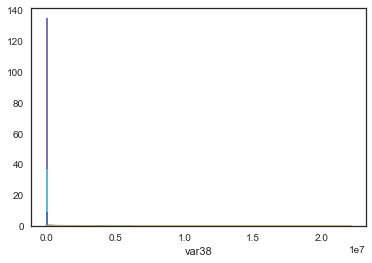

In [20]:
for c in train.select_dtypes('float'):
    sns.distplot(train[c]);

## Feature Engineering

### One Hot Encoding

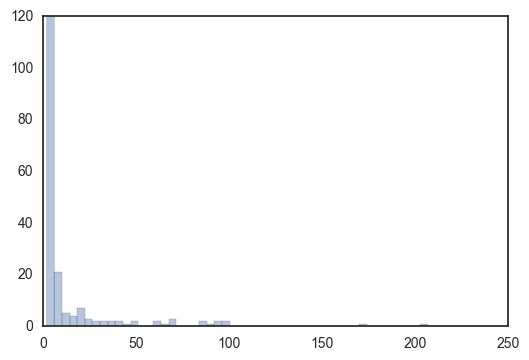

In [15]:
sns.distplot(train.select_dtypes('int').nunique(), kde=False);

In [16]:
def OHE(train = train, test = test, limit=10):
    oh_df = pd.concat([train, test])
    for c in oh_df.select_dtypes(int):
        if oh_df[c].nunique()>2 and oh_df[c].nunique()<limit:
            for val in set(oh_df[c]):
                train[c+'_oh_' + str(val)] = (train[c].values == val).astype(np.int)
                test[c+'_oh_' + str(val)] = (test[c].values == val).astype(np.int)            
#             train.drop(c, axis=1)
#             test.drop(c, axis=1)

OHE()

### Extra Features

#### Values sum

In [17]:
def values_sum(df):
    df['values_sum'] = df[features].sum(axis=1).astype(float)

values_sum(train)
values_sum(test)

#### Count zeros

In [18]:
def count_zeros(df):
    df['zeros'] = (df[features]==0).sum(axis=1).astype(float)
    
count_zeros(train)
count_zeros(test)

#### Value == Mode

In [19]:
def check_if_is_mode(df):
    modes = df.mode()
    for c in features:
        df['is_mode_of_'+c] = (df[c]==modes[c][0]).astype(int)

check_if_is_mode(train)
check_if_is_mode(test)

### Feature Scaling

In [20]:
# sns.countplot(train.dtypes);

In [21]:
# for f in train.select_dtypes('float').columns:
#     sns.distplot(train[f])

In [22]:
from sklearn.preprocessing import MinMaxScaler

min_max_scaler = MinMaxScaler()
floats = train.select_dtypes('float').columns
min_max_scaler.fit(pd.concat([train,test])[floats])
train[floats] = pd.DataFrame(min_max_scaler.transform(train[floats]), columns=floats)
test[floats] = pd.DataFrame(min_max_scaler.transform(test[floats]), columns=floats)

In [23]:
# for f in train.select_dtypes('float').columns:
#     sns.distplot(train[f].apply(lambda x: minimum_float/2 if x==0 else x).apply(np.log))

In [24]:
# for f in train.select_dtypes('float').columns:
#     m = train[f].mode()[0]
#     sns.distplot(train[train[f]!=m][f].apply(lambda x: minimum_float/2 if x==0 else x).apply(np.log))

In [ ]:
minimum_float = pd.concat([train.select_dtypes(float), test.select_dtypes(float)]).replace(0,10).min().min()
print('Minimum non-zero value in data is {:.10f}'.format(float(minimum_float)))

Minimum non-zero value in data is 0.0000000069


In [ ]:
floats = train.select_dtypes('float').columns

train[floats] = train[floats].applymap(lambda x: minimum_float/2 if x==0 else x).apply(np.log)
test[floats] = test[floats].applymap(lambda x: minimum_float/2 if x==0 else x).apply(np.log)

### Feature Selection

In [ ]:
def get_feature_importances(data):
    from sklearn.ensemble import RandomForestClassifier
    rf_classifier = RandomForestClassifier(random_state=3)

    n = len(data.drop('TARGET', axis=1).columns)
    
    X = np.array(data.drop('TARGET', axis=1))
    y = np.array(data['TARGET'])
    
    rf_classifier.fit(X, y)

    i_rf = rf_classifier.feature_importances_
    
    importances = pd.DataFrame({'i': i_rf}, index=data.drop('TARGET', axis=1).columns)
    importances.sort_values('i', ascending=False, inplace=True)
    
    return importances

importances = get_feature_importances(train)

In [ ]:
# sns.distplot(importances.i, kde=False);

In [ ]:
n_important = len(importances.loc[importances.i>importances.i.mean()])
n_important

In [ ]:
sns.distplot(importances.i.head(n_important), kde=False);

In [ ]:
from sklearn.model_selection import cross_val_score

In [ ]:
train = train[list(importances.head(n_important).index)+['TARGET']]
test = test[importances.head(n_important).index]

## Baselines

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

X = np.array(train.drop('TARGET', axis=1))
y = np.array(train['TARGET'])

In [ ]:
print(cross_val_score(xgb_classifier, X_top_features, y, cv=3, scoring='roc_auc').mean())
print(cross_val_score(mlp_classifier, X_top_features, y, cv=3, scoring='roc_auc').mean())
print(cross_val_score(lr_classifier, X_top_features, y, cv=3, scoring='roc_auc').mean())

## Parameter Optmization
#### Grid Search

In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
rf_clf = RandomForestClassifier(random_state=3)

rf_parameters = {'max_depth': [3, 6, 9, None],
                 'min_samples_leaf': [2, 10, 100],
                 'min_samples_split': [2, 20, 200],
                 'class_weight': [None, 'balanced'],
                 'n_estimators': [10, 100]
                }

rf_grid_obj = GridSearchCV(rf_clf, rf_parameters, scoring='roc_auc', verbose=1, cv=3)
rf_grid_obj = rf_grid_obj.fit(X, y)

rf_opt =  rf_grid_obj.best_estimator_
rf_opt


# rf_opt = RandomForestClassifier(bootstrap=True, class_weight='balanced',
#             criterion='gini', max_depth=9, max_features='auto',
#             max_leaf_nodes=None, min_impurity_decrease=0.0,
#             min_impurity_split=None, min_samples_leaf=2,
#             min_samples_split=200, min_weight_fraction_leaf=0.0,
#             n_estimators=100, n_jobs=1, oob_score=False, random_state=3,
#             verbose=0, warm_start=False)

In [ ]:
# mlp_clf = MLPClassifier(early_stopping=True)

# mlp_parameters = {'hidden_layer_sizes': [(100,), (200,100,10), (100,50,10)], 
#                   'learning_rate': ['constant', 'adaptive'],
#                   'learning_rate_init': [0.0001, 0.001, 0.01],
#                   'activation': ['relu', 'tanh']}

# mlp_grid_obj = GridSearchCV(mlp_clf, mlp_parameters, scoring='roc_auc', verbose=1, cv=3)
# mlp_grid_obj = mlp_grid_obj.fit(X, y)

# mlp_opt =  mlp_grid_obj.best_estimator_
# mlp_opt

mlp_opt = MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=True, epsilon=1e-08,
       hidden_layer_sizes=(200, 100, 10), learning_rate='adaptive',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

In [ ]:
# lr_clf = LogisticRegression()

# lr_parameters = {'class_weight': [{0:0.2, 1:0.8}],
#                'penalty': ['l1', 'l2'], 
#                'C': [0.01, 0.1, 0.5, 1.0], 
#                'fit_intercept': [True, False]}

    
# lr_grid_obj = GridSearchCV(lr_clf, lr_parameters, scoring='roc_auc', verbose=1, cv=3)
# lr_grid_obj = lr_grid_obj.fit(X, y)

# lr_opt =  lr_grid_obj.best_estimator_
# lr_opt

lr_opt = LogisticRegression(C=1.0, class_weight={0: 0.2, 1: 0.8}, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [ ]:
# xgb_clf = XGBClassifier(n_jobs=-1)

# xgb_parameters = {'max_depth': [3, 6, 9],
#                   'learning_rate': [0.01, 0.1],
#                   'n_estimators': [100]}
                
# xgb_grid_obj = GridSearchCV(xgb_clf, xgb_parameters, scoring='roc_auc', verbose=1, cv=3)
# xgb_grid_obj = xgb_grid_obj.fit(X, y)
# xgb_opt =  xgb_grid_obj.best_estimator_
# xgb_opt

xgb_opt = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=6, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=-1, nthread=None, objective='binary:logistic',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1)

In [ ]:
xgb_clf = XGBClassifier(n_jobs=-1)

xgb_parameters = {'max_depth': [3, 6, 9],
                  'learning_rate': [0.01, 0.1],
                  'n_estimators': [100]}
                
xgb_grid_obj = GridSearchCV(xgb_clf, xgb_parameters, scoring='roc_auc', verbose=1, cv=3)
xgb_grid_obj = xgb_grid_obj.fit(X, y, eval_metric=sklearn.metrics.roc_auc_score)
xgb_opt =  xgb_grid_obj.best_estimator_
xgb_opt

# xgb_opt = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
#        colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
#        max_depth=6, min_child_weight=1, missing=None, n_estimators=100,
#        n_jobs=-1, nthread=None, objective='binary:logistic',
#        random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
#        seed=None, silent=True, subsample=1)

## Model Selection & Submissions

In [ ]:
def save_submission(prediction, name):
    sub = pd.DataFrame()
    sub['id'] = test_id
    sub['target'] = prediction
    sub.to_csv(name+'.csv', index=False)

#### Random Forest

In [49]:
score = cross_val_score(rf_opt, X, y, scoring='roc_auc', cv=3).mean()
print('Cross validation score = {}'.format(score))

print('Fitting algorithm...')
rf_opt.fit(X,y)
y_pred = rf_opt.predict_proba(np.array(test))[:,1]

save_submission(y_pred, 'rf')
print('Predictions saved.')

Predictions saved.


#### Multi Layer Perceptron

In [ ]:
score = cross_val_score(mlp_opt, X, y, scoring='roc_auc', cv=3).mean()
print('Cross validation score = {}'.format(score))

print('Fitting algorithm...')
mlp_opt.fit(X,y)
y_pred = mlp_opt.predict_proba(np.array(test))[:,1]

save_submission(y_pred, 'mlp')
print('Predictions saved.')

#### Logistic Regression

In [ ]:
score = cross_val_score(lr_opt, X, y, scoring='roc_auc', cv=3).mean()
print('Cross validation score = {}'.format(score))

print('Fitting algorithm...')
lr_opt.fit(X,y)
y_pred = lr_opt.predict_proba(np.array(test))[:,1]

save_submission(y_pred, 'lr')
print('Predictions saved.')

#### XGBoost

In [ ]:
score = cross_val_score(xgb_opt, X, y, scoring='roc_auc', cv=3).mean()
print('Cross validation score = {}'.format(score))

print('Fitting algorithm...')
xgb_opt.fit(X,y)

y_pred = xgb_opt.predict_proba(np.array(test))[:,1]

save_submission(y_pred, 'xgb')
print('Predictions saved.')

#### XGBoost with eval metric

In [1]:
score = cross_val_score(xgb_opt, X, y, scoring='roc_auc', cv=3).mean()
print('Cross validation score = {}'.format(score))

print('Fitting algorithm...')
xgb_opt.fit(X,y, eval_metric=sklearn.metrics.roc_auc_score)

y_pred = xgb_opt.predict_proba(np.array(test))[:,1]

save_submission(y_pred, 'xgb')
print('Predictions saved.')

NameError: name 'cross_val_score' is not defined

## Undersampling
- This dataset is highly unbalanced, so using the new dataset without noise, I made an undersampling as follows: first, I splitted the dataset in the instances which have class label 0 and the instances which have class label 1. Later, I splitted the instances with 0 class into (number_of_class0/number_of_class1) partitions (24 partitions) and I joined each partition with the partition of instances of 1 class label made before. Finally, I ran xgboost on each new balanced partition and I made an average with the predictions of the 24 models.
- Add this undersampling method to cross val function, with partameter to toggle on/off.

In [83]:
def undersample(train, test, model):
    zeros = train[train.TARGET==0].sample(frac=1).reset_index(drop=True)
    ones = train[train.TARGET==1]

    folds = []
    predictions = []

    for i in range(0, len(zeros), len(ones)):
        zeros_fold = zeros[i:i+len(ones)]
        ones_fold = ones.sample(len(zeros_fold))
        fold = pd.concat([zeros_fold, ones_fold])
        folds.append(fold)

    for fold in folds: 
        X = np.array(fold.drop('TARGET', axis=1))
        y = np.array(fold['TARGET'])
        model.fit(X, y)
        fold_pred = model.predict_proba(np.array(test))[:,1]
        predictions.append(fold_pred)
    
    return pd.DataFrame(predictions).mean()

In [84]:
y_pred = undersample(train, test, xgb_opt)

save_submission(y_pred, 'us')
print('Predictions saved.')

Predictions saved.


---

In [79]:
train_pred = undersample(train, train.drop('TARGET', axis=1), xgb_opt)

In [80]:
p = pd.DataFrame()
p['pred'] = (train_pred>0.5).astype(int)
p['real'] = train.TARGET

In [68]:
from sklearn.metrics import confusion_matrix
pd.DataFrame(confusion_matrix((train_pred>0.5).astype(int), train.TARGET))

,0,1
0,55776,387
1,17236,2621


In [81]:
from sklearn.metrics import confusion_matrix
pd.DataFrame(confusion_matrix((train_pred>0.5).astype(int), train.TARGET))

,0,1
0,62724,746
1,10288,2262


## Ideas
- Add noise to target
- Add noise to target after folding, and train a regressor.
- Replicate datapoints with TARGET=1. 
- Replicate datapoints with TARGET=1. Add noise.
- Unbalanced features: check if they give info about target. Try to combine them. Remove excess.
- Remaining features: check if they give info using FacetGrid. Apply transformations and check again. Trying to kernel trick.
- Simplyfy cross-validation using only sklearn's cross_val_score.
- Remove datapoints that have outliers if target=0
- Submit using Kaggle api. import kaggle
- plotar distribuicao dos scores finais da competicao
- mostrar minha posicao comparada as outras notas sem rankear. estara mto mais proxima do primeiro lugar do que do benchmark
- ao terminar o projeto, responder email antigo da cristina junqueira
- Review previous projects' and live's notebooks ot see if there's something to be added
- Test the baseline with unprocessed data
- Test the baseline with unscaled data
- GridSearch again at the end, after feature engineering
- SVM on low importance features.
- drop duplicated columns. `train.T.drop_duplicates().T`
- fit scaler to whole data (train + test)
- Try more base models with final data
- Train models only on misclassified datapoints to serve as features for the final model
- Link MLP http://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html
- log scaler
- OneHotEncode'em all
- Binary feature for each feature on the dataset. `1 if feature == feature.mode() else 0`
- Add column that sum zeros on row. `train['zeros'] = (train==0).sum(axis=1).astype(float)`
- Add column that sums values in row. 
- PCA and other dimensionality reduction on low importance features.
- ONE-HOT encode features with more than 2 and less than 'limit' unique values
- Test importance of new features
- Stacking / Voting
- Classifiers as features
- Sklearn Pipeline
- Sklearn feature selection

## Rascunho

In [223]:
## Stacking Models

# def stack(train, test, models):    
#     X_train = np.array(train.drop('TARGET', axis=1))
#     y_train = np.array(train['TARGET'])
#     X_test = np.array(test)
    
#     train_probas = []
#     test_probas = []

#     for model in models:
#         model.fit(X_train, y_train)
#         train_probas.append(model.predict_proba(X_train)[:,1])
#         test_probas.append(model.predict_proba(X_test)[:,1])
        
#     stack_perceptron = MLPClassifier(hidden (3,2), early)
    
#     stack_perceptron.fit(train_probas, y_train)
#     stack_perceptron.predict_proba(test_probas)[:,1]

In [59]:
# MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
#        beta_2=0.999, early_stopping=True, epsilon=1e-08,
#        hidden_layer_sizes=(200, 100, 10), learning_rate='constant',
#        learning_rate_init=0.001, max_iter=200, momentum=0.9,
#        nesterovs_momentum=True, power_t=0.5, random_state=None,
#        shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
#        verbose=False, warm_start=False)

In [60]:
# LogisticRegression(C=0.1, class_weight={0: 0.2, 1: 0.8}, dual=False,
#           fit_intercept=False, intercept_scaling=1, max_iter=100,
#           multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
#           solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [61]:
# XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
#        colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
#        max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
#        n_jobs=-1, nthread=None, objective='binary:logistic',
#        random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
#        seed=None, silent=True, subsample=1)

In [11]:
# XGBoost params
xgb_params = {}
xgb_params['learning_rate'] = 0.2
xgb_params['n_estimators'] = 10
xgb_params['max_depth'] = 4
xgb_params['subsample'] = 0.9
xgb_params['colsample_bytree'] = 0.9

In [12]:
XGB_model = XGBClassifier(**xgb_params)

In [15]:
XGB_model.fit(X,y, eval_metric=roc_auc_score)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.9, gamma=0, learning_rate=0.2, max_delta_step=0,
       max_depth=4, min_child_weight=1, missing=None, n_estimators=10,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.9)

In [229]:
# - Missing values. `train.columns[train.isnull().any()].tolist()`
# - Outliers and strange values
# - Remove duplicated features
# - Remove useless features
# - Remove useless and duplicated features checking it not only on training set but also on testing set (but maybe they could be useful on validation set).
# - This dataset has some repeated instances but with both class label, so that instances are noise. What I made was extract that noisy instances from the complete dataset. After that, I splitted the resulting complete dataset in 5 partitions and I ran xgboost on each one. Then, I made a majority vote of the five resulting predictions for each noisy instance that I extrated at the begining. Finally, I inserted that instances with the real class label.

### Dependencies

# import pandas as pd
# import numpy as np
# from time import time
# from matplotlib import pyplot as plt
# import seaborn as sns
# import random
# from collections import Counter
# from sklearn.preprocessing import MinMaxScaler
# from sklearn.preprocessing import RobustScaler
# from sklearn.preprocessing import OneHotEncoder
# import kaggle
# from sklearn.model_selection import StratifiedKFold
# from sklearn.metrics import roc_auc_score
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.naive_bayes import GaussianNB as NaiveBayes
# from sklearn.tree import DecisionTreeClassifier as DecisionTree
# from sklearn.svm import SVC
# from sklearn.linear_model import LogisticRegression
# from sklearn.neural_network import MLPClassifier
# import itertools
# import missingno as msno
# import gc
# from sklearn.metrics import f1_score
# from sklearn.metrics import make_scorer
# from sklearn.metrics import silhouette_score
# from sklearn.preprocessing import StandardScaler
# from sklearn.model_selection import GridSearchCV
# from sklearn.model_selection import cross_val_score
# from sklearn.model_selection import train_test_split
# from sklearn.model_selection import StratifiedKFold
# from sklearn.linear_model import LogisticRegression
# from sklearn.naive_bayes import GaussianNB as NaiveBayes
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.tree import DecisionTreeRegressor
# from sklearn.svm import SVC as SVM
# from xgboost import XGBClassifier
# from lightgbm import LGBMClassifier
# from catboost import CatBoostClassifier
# from sklearn.decomposition import PCA
# from sklearn.mixture import GaussianMixture as GM
# from hyperopt.pyll.base import scope
# from hyperopt.pyll.stochastic import sample
# from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
# from xgboost import XGBClassifier
# from lightgbm import LGBMClassifier
# from catboost import CatBoostClassifier

### Viz

# sns.palplot(sns.color_palette())

# from IPython.display import display # Allows the use of display() for DataFrames
# from IPython.display import set_matplotlib_formats
# pd.options.display.float_format = '{:.2f}'.format
# # sns.set(color_codes=True, palette=sns.palplot(sns.cubehelix_palette(8)))
# # sns.set_palette("cubehelix_palette")
# %matplotlib inline
# # set_matplotlib_formats('pdf', 'png')
# rc={'savefig.dpi': 75,    'figure.autolayout': False,    'figure.figsize': [8, 6],    'axes.labelsize': 18,    'axes.titlesize': 18,    'font.size': 18,    'lines.linewidth': 2.0,    'lines.markersize': 8,    'legend.fontsize': 16,    'xtick.labelsize': 16,    'ytick.labelsize': 16,    }
# # sns.set(style='dark')
# sns.set(style='dark',rc=rc)
# # default_color = '#56B4E9'
# colormap = plt.cm.cool
# # Import supplementary visualizations code visuals.py
# # import visuals as vs
# # Setting working directory
# # path = '../data/raw/'
# sns.set_palette(sns.cubehelix_palette(50))
# sns.set_palette('GnBu_d')
# sns.palplot(sns.color_palette())